In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sb
import matplotlib as mlp
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
pb_tvc = pd.read_excel("../../../../Outcome Measurement Data/HIV/SIGPRO/sigpro_f4_completo.xlsx", 0)
its = pd.read_excel("../../../../Outcome Measurement Data/HIV/SIGPRO/sigpro_f4_completo.xlsx", 1)
aa = pd.read_excel("../../../../Outcome Measurement Data/HIV/SIGPRO/sigpro_f4_completo.xlsx", 2)
vinculacion = pd.read_excel("../../../../Outcome Measurement Data/HIV/SIGPRO/sigpro_f4_completo.xlsx", 3)
psico = pd.read_excel("../../../../Outcome Measurement Data/HIV/SIGPRO/sigpro_f4_completo.xlsx", 4)

In [5]:
ejecutores = {
    "NAC0401": "CAS",
    "NAC0402": "OTRANS",
    "NAC0403": "FUNDACION MARCO ANTONIO", 
    "NAC0404": "ASOCIACION IDEI",
    "NAC0405": "FUNDACION FERNANCO ITURBIDE",
    "NAC0101": "HIVOS"
}


In [6]:
pb_tvc["Ejecutores"] = pb_tvc.codejecutor.replace(ejecutores)
pb_tvc["Mes"] = pb_tvc.fechareal.apply(lambda x: str(x)[0:7])
pb_tvc.columns

Index(['numeroInforme', 'codigoActividad', 'codigounico', 'codgrupo',
       'codsubgrupo', 'refervih', 'prePruebaVIH', 'pruebaVIH', 'postPruebaVIH',
       'conoceResultadoVIH', 'codResultadoVIH', 'conoceResultadoSif',
       'codResultadoSif', 'condonesMasculinos', 'condonesFemeninos',
       'condonesSabores', 'lubriSachet', 'lubriTubo', 'impresos', 'grupo',
       'subgrupo', 'resultadoVIH', 'codejecutor', 'codanno', 'codmes',
       'codigoTipoActividad', 'tipoActividad', 'resultadoSif', 'codDepMun',
       'lugar', 'direccion', 'responsable', 'educador', 'unmovil', 'fechareal',
       'departamento', 'municipio', 'tema', 'Ejecutores', 'Mes'],
      dtype='object')

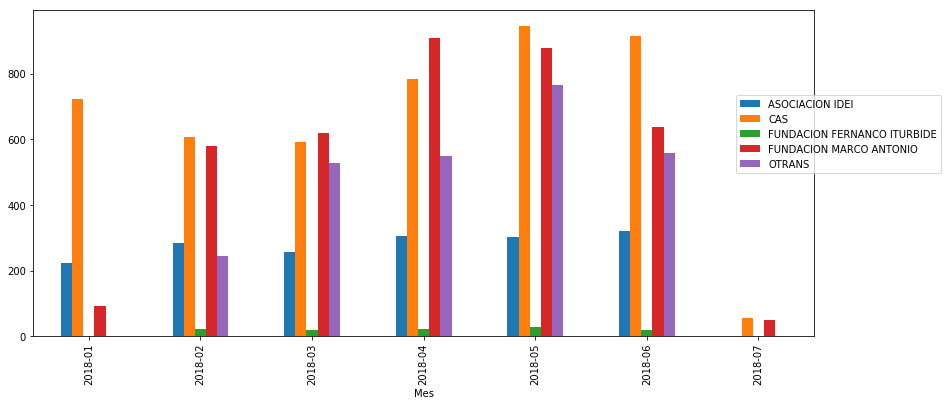

In [7]:
plt.rcParams["figure.figsize"] = (14,6)
temp = pb_tvc[pb_tvc.Mes != "NaT"].groupby(["Ejecutores", "Mes"]).numeroInforme.count()
temp.unstack(0).plot.bar()
plt.legend(loc=(0.9,0.5))

In [ ]:
plt.rcParams["figure.figsize"] = (14,6)
temp = pb_tvc[(pb_tvc.Mes != "NaT") & (pb_tvc.Ejecutores.isin(["FUNDACION FERNANCO ITURBIDE", "HIVOS"])==False)]\
        .groupby(["Ejecutores", "resultadoVIH"]).numeroInforme\
        .count().unstack(1).fillna(0)
temp["total"] = temp.sum(axis=1)
temp2 = temp.divide(temp.total, axis = 0)*100
temp2[temp2.columns.tolist()[0:-1]].plot.bar()
plt.legend(loc=(0.95,0.5))
plt.grid()

In [ ]:
plt.rcParams["figure.figsize"] = (5,10)
temp = pb_tvc[(pb_tvc.Mes != "NaT") ]\
        .groupby(["subgrupo", "resultadoVIH"]).numeroInforme\
        .count().unstack(1).fillna(0)
temp["total"] = temp.sum(axis=1)
temp2 = temp.divide(temp.total, axis = 0)*100
temp2

In [9]:
merged = pb_tvc.merge(its, on = "codigounico", suffixes = ("", "_its"), how = "outer")\
        .merge(vinculacion, on = "codigounico", suffixes = ("", "_vinc"), how = "outer")

In [10]:
def process(data):
    return pd.Series(data = [
        len(data), 
        (data.numeroInforme_its.isna()==False).sum(),
        (data.resultadoVIH == "REACTIVO").sum(),
        (data.numeroInforme_vinc.isna()==False).sum()
    ], index=["PB/TVC", "ITS", "VIH Reactivo", "Vinculación"])
temp = merged[merged.subgrupo.apply(lambda x: x.startswith("PV ")==False if type(x) == str else True)]\
        .groupby("subgrupo").apply(process).fillna(0)
#temp["total"] = temp.sum(axis=1)
temp2 = temp.divide(temp["PB/TVC"], axis = 0) * 100
#temp.loc["total"] = temp.sum(axis=0)
print(temp2.round(2))
temp.loc["total"] = temp.sum(axis=0)
print("\n\n")
print(temp.divide(temp.loc["total"], axis = 1).round(4)*100)
print("\n\n")
temp3 = temp[["PB/TVC", "VIH Reactivo", "Vinculación"]].copy()
temp3["VIH Reactivo"] = temp3["VIH Reactivo"]/temp3["PB/TVC"]
temp3["Vinculación"] = temp3["Vinculación"]/temp3["PB/TVC"]/temp3["VIH Reactivo"]

temp3.round(3).fillna(0)*100
    #print(temp.divide(temp.loc["total"], axis = 1).round(4)*100)

                              PB/TVC    ITS  VIH Reactivo  Vinculación
subgrupo                                                              
HSH ADOLESCENTES Y JOVENES     100.0  53.75          6.25         3.75
HSH MAYORES DE 18 AÃ‘OS        100.0  43.56          3.03         2.03
TRANS ADOLESCENTES Y JOVENES   100.0   0.00          0.00         0.00
TRANS DE DIFERENTES PUEBLOS    100.0   9.89          7.14         4.95
TRANS MAYORES DE 18 AÃ‘OS      100.0   9.78          1.52         0.91
TRANS MIGRANTES                100.0   0.00          0.00         0.00
TRANS TRABAJADORAS SEXUALES    100.0   8.70          0.00         0.00



                              PB/TVC     ITS  VIH Reactivo  Vinculación
subgrupo                                                               
HSH ADOLESCENTES Y JOVENES      0.57    0.86          1.29         1.17
HSH MAYORES DE 18 AÃ‘OS        74.71   92.29         82.47        83.59
TRANS ADOLESCENTES Y JOVENES    0.02    0.00          0.00         0.0

,PB/TVC,VIH Reactivo,Vinculación
subgrupo,,,
HSH ADOLESCENTES Y JOVENES,8000,6.2,60.0
HSH MAYORES DE 18 AÃ‘OS,1055200,3.0,66.9
TRANS ADOLESCENTES Y JOVENES,300,0.0,0.0
TRANS DE DIFERENTES PUEBLOS,18200,7.1,69.2
TRANS MAYORES DE 18 AÃ‘OS,328300,1.5,60.0
TRANS MIGRANTES,100,0.0,0.0
TRANS TRABAJADORAS SEXUALES,2300,0.0,0.0
total,1412400,2.7,66.0


In [15]:
merged.groupby(["Ejecutores", "subgrupo"]).apply(process).fillna(0).reset_index()

,Ejecutores,subgrupo,PB/TVC,ITS,VIH Reactivo,Vinculación
0,ASOCIACION IDEI,HSH ADOLESCENTES Y JOVENES,4,0,0,0
1,ASOCIACION IDEI,HSH MAYORES DE 18 AÃ‘OS,1481,354,14,11
2,ASOCIACION IDEI,TRANS MAYORES DE 18 AÃ‘OS,357,65,4,0
3,ASOCIACION IDEI,TRANS TRABAJADORAS SEXUALES,3,0,0,0
4,CAS,HSH ADOLESCENTES Y JOVENES,76,43,5,3
5,CAS,HSH MAYORES DE 18 AÃ‘OS,5360,3774,202,136
6,FUNDACION FERNANCO ITURBIDE,PV ABORDADA EN OTROS LUGARES,112,0,0,0
7,FUNDACION FERNANCO ITURBIDE,PV ABORDADA EN UAI,1,0,0,0
8,FUNDACION MARCO ANTONIO,HSH MAYORES DE 18 AÃ‘OS,3710,468,104,67
9,FUNDACION MARCO ANTONIO,TRANS DE DIFERENTES PUEBLOS,181,18,13,9


In [1]:
1

1